# COMP5328 - Advanced Machine Learning

## Assignment 1: Non-negative Matrix Factorization

- Tutors: Siyu Xu
- Group members:
    - Kaiyue Wang (ID: 530402325, UniKey: kwan5221)
    - Peng Huang (ID: 530203700, UniKey: phua0038)
    - Shoudi Huang (ID: 500478204, Unikey: shua9875)

## 1. Initialization

### 1.1 Import Libraries

In [1]:
# For common use
import os
import io
import json
import time
import datetime
import matplotlib.pyplot as plt
from PIL import Image
import numpy

np = numpy

# For evaluation only
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, mean_squared_error
from collections import Counter

DEBUG_MODE = True

### 1.2 Initialize on Colab (with GPU, optional)

Our code file is compatible with both CPU and GPU environments, with the GPU offering faster computational speeds, and is also supported for environment within Colab.

In [2]:
USE_COLABS = False # Set this to True when using Colab for downloading the dataset
GPU_MODE = False
if USE_COLABS:
    # libraries for downloading files from google drive
    from pydrive.auth import GoogleAuth
    from google.colab import drive
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    file_id = '1D5A2IHrd2QCPlowlFENT2zyrctgnDVQU' # This is the dataset share id

    download = drive.CreateFile({'id': file_id})


    # Download the file to a local disc
    download.GetContentFile('data.zip')

    # unzip the download file
    !unzip data.zip

In [3]:
if GPU_MODE:
    # For Checking GPU Avaliability only
    import torch
    # Check for the availability of a GPU
    if torch.cuda.is_available():
        print(f'GPU is available. Device name: {torch.cuda.get_device_name()}')
        try:
            import cupy
        except Exception as e:
            !pip install cupy-cuda12x # install the cupy module based on your GPU version, if GPU avaliable
            import cupy
        np = cupy
    else:
        GPU_MODE = False
        print('GPU is not available.')

## 2. Load Dataset and Preprocessing

- The ORL dataset contains 400 images of 40 distinct subjects each image is cropped and resized to $92\times112$ pixels. Considering the computation cost, we reduce the resolution of the input image by a factor of 2 to $46\times56$ pixels.
- For the extended YaleB dataset, it contains 2414 images of 38 subjects under 9 poses and 64 illumination conditions and all images are resized to $168\times192$ pixels. Considering the computation cost, we reduce the resolution of the input image by a factor of 4 to $42\times48$ pixels.


### 2.1 Function for Loading the Datasets

- Convert each image to a column vector and merge all column vectors into a matrix
- Reduce the size of the image and the computation cost
- Preprocessing: Normalization - Divided data points by 255 and rescale it to range 0 to 1


In [4]:
def load_data(root='data/CroppedYaleB', reduce=4):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []
    image_size = None

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')  # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])
            image_size = img.size

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1, 1))

            # pre-processing
            # Normalize the image data from the range [0, 255] to [0, 1].
            img = img / 255

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels, image_size[0], image_size[1]

### 2.2 Function for Displaying Images

In [5]:

# For mock test
def original(image_data_array, image_height, image_width):
    return image_data_array.reshape((-1, 1))


def contaminate_dataset(X_hat, image_height, image_width, contaminate_function):
    """
    Contaminates a dataset by applying a given contaminate_function to each element.
    
    Parameters:
    - X_hat (np.array): The dataset to be contaminated.
    - image_height (int): Height of the image.
    - image_width (int): Width of the image.
    - contaminate_function (function): A noise function.
    
    Returns:
    - np.array: X_hat_contaminated from X_hat has been contaminated using the provided contaminate_function.
    """

    X_hat_contaminated = []
    for i in range(0, X_hat.shape[1]):
        X_hat_contaminated.append(contaminate_function(
            X_hat[:, i], image_height, image_width))
    return np.hstack(X_hat_contaminated)


def show_original_and_processed_iamge(X_hat, X_hat_processed, image_height, image_width, titles=["Original\nImage", "Contaminated\nImage"]):
    """
    Displays a side-by-side comparison of original and processed images.
    
    Parameters:
    - X_hat (np.array): The original images dataset.
    - X_hat_processed (np.array): The processed version of the original images.
    - image_height (int): Height of the images.
    - image_width (int): Width of the images.
    - titles (list of str, optional): Titles for the display. Defaults to ["Original\nImage", "Contaminated\nImage"].
    """

    if GPU_MODE:
        X_hat = np.asnumpy(X_hat)
        X_hat_processed = np.asnumpy(X_hat_processed)

    # Create a plotting figure and axis
    fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(10, 3))

    # Set titles for the original and processed images sections
    axs[0, 0].text(0, 0.5, s=titles[0], size=10)
    axs[1, 0].text(0, 0.5, s=titles[1], size=10)
    axs[1, 0].axis('off')
    axs[0, 0].axis('off')

    # Display up to 6 pairs of original and processed images
    for i in range(6):
        image_matrix_array = X_hat[:, i].reshape(image_height, image_width)
        noise_image_matrix_array = X_hat_processed[:, i].reshape(
            image_height, image_width)

        axs[0, i + 1].imshow(image_matrix_array,
                             cmap=plt.cm.gray, vmax=1, vmin=0)
        axs[0, i + 1].axis('off')
        axs[0, i + 1].set_title('{}'.format(i))
        axs[1, i + 1].imshow(noise_image_matrix_array,
                             cmap=plt.cm.gray, vmax=1, vmin=0)
        axs[1, i + 1].axis('off')
    plt.show()

In [6]:
if DEBUG_MODE:
    X_hat, Y_hat, image_width, image_height = load_data(
        root='../data/ORL' if not USE_COLABS else 'data/ORL', reduce=2)
    print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}, image_width = {}, image_height = {}'.format(
        X_hat.shape, Y_hat.shape, image_width, image_height))

ORL dataset: X_hat.shape = (2576, 400), Y_hat.shape = (400,), image_width = 46, image_height = 56


## 3. Adding Noise

Three Different Noise was used in this study: 
- *Block Occlusion Noise*
- *Gauss Noise*
- *Salt and Pepper Noise*

### 3.1 Function for Block Occlusion Noise

In [7]:
def block_occlusion_noise(image_data_array, image_height, image_width, block_size=None):
    """
    Introduces occlusion noise to an image by creating a block occlusion.
    
    Parameters:
    - image_data_array (np.array): The original image data as a flattened array.
    - image_height (int): The height of the image.
    - image_width (int): The width of the image.
    - block_size (int, optional): The size of the block to introduce as noise. If not provided, a random size between 30% and 50% of the image's height is chosen.
    
    Returns:
    - np.array: The contaminated image data as a flattened array with the introduced block of noise.
    """
 
    # If block size is not provided, randomly select a size between 30% and 50% of the image's height
    if block_size == None:
        block_size = int(image_height * (0.3 + np.random.rand() * 0.2))

    # Make a copy of the original image and reshape it for processing
    contaminated_image = image_data_array.copy()
    contaminated_image = contaminated_image.reshape(
        (image_height, image_width))

    # Randomly select the offset coordinate within the appropriate range of the image.
    block_position_row = int((image_height - block_size) * np.random.rand())
    block_position_col = int((image_width - block_size) * np.random.rand())

    # Introduce the block of noise in the selected position
    for i in range(0, block_size):
        for j in range(0, block_size):
            contaminated_image[block_position_row +
                               i][block_position_col + j] = 1

    # Reshape the contaminated image back to a flattened array and clip values between 0 and 1
    contaminated_image = contaminated_image.reshape((-1, 1))
    contaminated_image = np.clip(contaminated_image, 0, 1)
    return contaminated_image

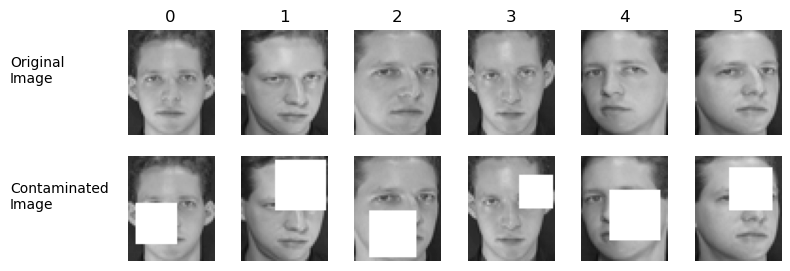

In [8]:
if DEBUG_MODE:
    X_hat_contaminated = contaminate_dataset(
        X_hat, image_height, image_width, block_occlusion_noise)
    show_original_and_processed_iamge(
        X_hat, X_hat_contaminated, image_height, image_width)

### 3.2 Function for Gauss Noise

In [9]:
def gauss_noise(image_data_array, image_height, image_width, mean=0, sigma=0.1):
    """
    Adds Gaussian noise to an image.
    
    Parameters:
    - image_data_array (np.array): The original image data as a flattened array.
    - image_height (int): The height of the image.
    - image_width (int): The width of the image.
    - mean (float, optional): The mean of the Gaussian noise to be added. Defaults to 0.
    - sigma (float, optional): The standard deviation of the Gaussian noise, which controls the intensity of the noise. Defaults to 0.1.
    
    Returns:
    - np.array: The contaminated image data as a flattened array with the added Gaussian noise.
    """

    # Generate Gaussian noise based on the provided mean and standard deviation
    gaussian_noise = np.random.normal(mean, sigma, image_data_array.shape)

    # Add the Gaussian noise to the original image
    contaminated_image = image_data_array + gaussian_noise

    # Reshape the contaminated image to a flattened array and clip values to be between 0 and 1
    contaminated_image = contaminated_image.reshape((-1, 1))
    contaminated_image = np.clip(contaminated_image, 0, 1)
    return contaminated_image

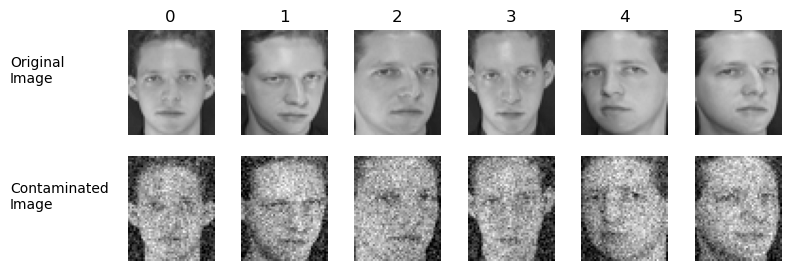

In [10]:
if DEBUG_MODE:
    X_hat_contaminated = contaminate_dataset(
        X_hat, image_height, image_width, gauss_noise)
    show_original_and_processed_iamge(
        X_hat, X_hat_contaminated, image_height, image_width)

### 3.3 Function for Salt and pepper noise

In [11]:
def salt_and_pepper_noise(image_data_array, image_height, image_width, percentage=0.1):
    """
    Adds salt and pepper noise to an image.
    
    Parameters:
    - image_data_array (np.array): The original image data as a flattened array.
    - image_height (int): The height of the image.
    - image_width (int): The width of the image.
    - percentage (float, optional): The percentage of pixels in the image that will have salt and pepper noise applied. Defaults to 0.1.
    
    Returns:
    - np.array: The contaminated image data as a flattened array with the added salt and pepper noise.
    """
    
    # Create a copy of the original image data to work with
    contaminated_image = image_data_array.copy()

    # Randomly select a set of indices based on the given percentage
    noise_dots = np.random.randint(
        0, len(image_data_array), int(len(image_data_array) * percentage))

    # For each randomly selected index, set the value to either 0 (black) or 1 (white), representing salt or pepper
    for noise_dot in noise_dots:
        contaminated_image[noise_dot] = np.random.randint(0, 2) * 1

    # Reshape the contaminated image to a flattened array and clip values to be between 0 and 1
    contaminated_image = contaminated_image.reshape((-1, 1))
    contaminated_image = np.clip(contaminated_image, 0, 1)
    return contaminated_image

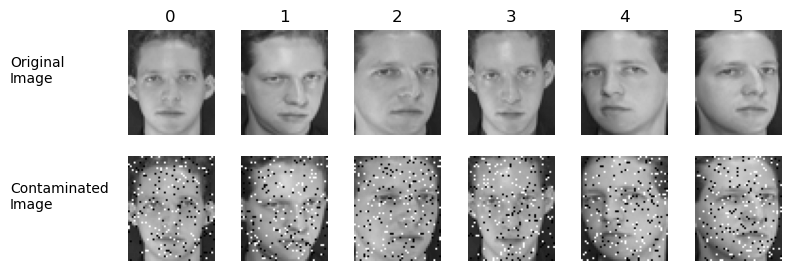

In [12]:
if DEBUG_MODE:
    X_hat_contaminated = contaminate_dataset(
        X_hat, image_height, image_width, salt_and_pepper_noise)
    show_original_and_processed_iamge(
        X_hat, X_hat_contaminated, image_height, image_width)

## 4. Functions for Evaluation Metrics

1. Root Mean Square Error (RMSE)

$$    \mathrm{RMSE} = \sqrt{\frac{1}{N} {\| \hat{X} - DR \|}_F^2}$$

2. Accuracy (ACC)

$$\mathrm{Acc}(Y, Y_{pred}) = \frac{1}{n}\sum_{i=1}^n 1\{Y_{pred(i)} == Y(i)\}$$

3. Normalized Mutual Information (NMI)

$$\mathrm{NMI}(Y, Y_{pred}) = \frac{2*I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}$$

 Where $I(.,.)$ is mutual information and  $𝐻(⋅)$ is entropy.

In [13]:
def construct_RMSE(X, Y):
    if (GPU_MODE == True):
        RMSE = np.sqrt(mean_squared_error(np.asnumpy(X), np.asnumpy(Y)))
        RMSE = RMSE.item()
    else:
        RMSE = np.sqrt(mean_squared_error(X, Y))

    return RMSE


def assign_cluster_label(x, y):
    if (GPU_MODE == True):
        X = np.asnumpy(x)
        Y = np.asnumpy(y)
    else:
        X = x
        Y = y
    kmeans = KMeans(n_clusters=len(set(Y)), n_init='auto').fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]  # assign label.
    return Y_pred


def calculate_accuracy(y, y_pred):
    if (GPU_MODE == True):
        Y = np.asnumpy(y)
        Y_pred = np.asnumpy(y_pred)
    else:
        Y = y
        Y_pred = y_pred

    return accuracy_score(Y, Y_pred)


def calculate_NMI(y, y_pred):
    if (GPU_MODE == True):
        Y = np.asnumpy(y)
        Y_pred = np.asnumpy(y_pred)
    else:
        Y = y
        Y_pred = y_pred

    return normalized_mutual_info_score(Y, Y_pred)

## 5. NMF algorithms implementation


### 5.1 Funtion for $L_2$-NMF

- Objective function

$$\mathbf{D,R} = \min_{D, R} \| X - DR \|_F$$

- MUR

$$
    D_{ij} = D_{ij} \frac{(XR^T)_{ij}}{(DRR^T)_{ij}}\\
$$
$$
    R_{ij} = R_{ij} \frac{(D^TX)_{ij}}{(D^TDR)_{ij}}
$$

In [14]:
def l2_nmf(X, Y, max_steps=5000, tolerance=0.0005):
    """
    Implements L2-NMF for data matrix X.
    
    Parameters:
    - X (np.array): Data matrix with shape (m, n) where m is the number of features and n is the number of samples.
    - Y (np.array): Label array for the data matrix X.
    - max_steps (int, optional): Maximum number of iterations for the NMF algorithm. Defaults to 5000.
    - tolerance (float, optional): Convergence tolerance for the update steps. Defaults to 0.0005.
    
    Returns:
    - tuple: A tuple (D_updated, R_updated) representing the factorized matrices.
    """
    
    m = X.shape[0]
    n = X.shape[1]
    if (GPU_MODE == True):
        k = np.unique(Y).size
    else:
        k = len(set(Y))

    # Initialize matrices D and R with random values
    D = np.random.rand(m, k)
    R = np.random.rand(k, n)
    D_updated = None
    R_updated = None

    for step in range(0, max_steps):

        # Update rules for R and D matrices using the L2-NMF approach
        R_denominator = D.T @ D @ R
        R_denominator[R_denominator == 0] = np.finfo(np.float32).eps
        R_updated = (R * (D.T @ X) / R_denominator)

        D_denominator = D @ R_updated @ R_updated.T
        D_denominator[D_denominator == 0] = np.finfo(np.float32).eps
        D_updated = (D * (X @ R_updated.T) / D_denominator)

        # Calculate errors to check convergence
        D_error = np.sqrt(np.sum((D_updated - D) ** 2) / D.size)
        R_error = np.sqrt(np.sum((R_updated - R) ** 2) / R.size)

        # Check if errors are below the tolerance level
        if D_error < tolerance and R_error < tolerance:
            print("Converged at step:", step)
            break

        # Update matrices D and R
        D = D_updated
        R = R_updated

    print("Stop at step:", step)
    return D_updated, R_updated

Converged at step: 455
Stop at step: 455
RMSE(original)=0.090292
RMSE(contaminated)=0.169177


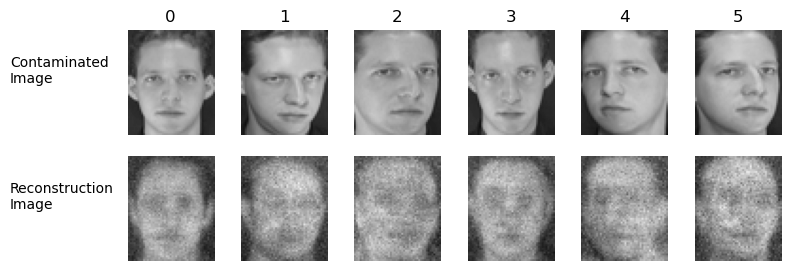

In [15]:
if DEBUG_MODE:
    D, R = l2_nmf(X_hat_contaminated, Y_hat)
    X_pred = D @ R
    RMSE = construct_RMSE(X_hat, X_pred)
    print('RMSE(original)=%f' % (RMSE))
    RMSE = construct_RMSE(X_hat_contaminated, X_pred)
    print('RMSE(contaminated)=%f' % (RMSE))
    show_original_and_processed_iamge(
        X_hat, X_pred, image_height, image_width, ["Contaminated\nImage", "Reconstruction\nImage"])

### 5.2 Function for Cauchy-NMF

- Objective function
$$\min_{D, R} \sum_{i=1}^{N} \sum_{j=1}^{M} \ln \left(\left\|X_{i, j}-\sum_{k=1}^{K} D_{i k} R_{kj}\right\|^{2}+\gamma^{2}\right) \quad$$

- MUR
$$
    \Delta_{i i}= \frac{1}{\sum_{j=1}^{p}(X - D R)^2_{ij} + \gamma^{2}}\\
$$
$$
    D_{j k} =  D_{j k} \frac{\left(X \Delta R^{T}\right)_{j k}}{\left(D R \Delta R^{T}\right)_{j k}} \\
$$
$$
    R_{k i} = R_{k i} \frac{\left(D^{T} X \Delta \right)_{k i}}{\left(D^{T} D R \Delta \right)_{k i}}
$$

In [16]:
def cauchy_nmf(X, Y, max_steps=5000, gamma=1, tolerance=0.0005):
    """
    Implements Cauchy-NMF for data matrix X.
    
    Parameters:
    - X (np.array): Data matrix with shape (m, n) where m is the number of features and n is the number of samples.
    - Y (np.array): Label array for the data matrix X.
    - max_steps (int, optional): Maximum number of iterations for the NMF algorithm. Defaults to 5000.
    - gamma (float, optional): Scaling factor for the Cauchy noise. Defaults to 1.
    - tolerance (float, optional): Convergence tolerance for the update steps. Defaults to 0.0005.
    
    Returns:
    - tuple: A tuple (D_updated, R_updated) representing the factorized matrices.
    """
    
    m = X.shape[0]
    n = X.shape[1]
    if (GPU_MODE == True):
        k = np.unique(Y).size
    else:
        k = len(set(Y))

    # Initialize matrices D and R with random values
    D = np.random.rand(m, k)
    R = np.random.rand(k, n)
    Delta = np.zeros((n, n))
    D_updated = None
    R_updated = None

    for step in range(0, max_steps):

        # Calculate the error matrix
        E = X - (D @ R)
        E[E == 0] = np.finfo(np.float32).eps

        # Compute the diagonal matrix for Cauchy-based updates
        Delta = np.diag(1 / ((np.linalg.norm(E, axis=0)**2) + (gamma**2)))

        # Update rules for D and R matrices using the Cauchy-NMF approach
        D_denominator = D @ R @ Delta @ R.T
        D_denominator[D_denominator == 0] = np.finfo(np.float32).eps
        D_updated = D * ((X @ Delta @ R.T) / D_denominator)

        R_denominator = D_updated.T @ D_updated @ R @ Delta
        R_denominator[R_denominator == 0] = np.finfo(np.float32).eps
        R_updated = R * ((D_updated.T @ X @ Delta) / R_denominator)

        # Calculate errors to check convergence
        D_error = np.sqrt(np.sum((D_updated - D) ** 2) / D.size)
        R_error = np.sqrt(np.sum((R_updated - R) ** 2) / R.size)

        # Check if errors are below the tolerance level
        if D_error < tolerance and R_error < tolerance:
            print("Converged at step:", step)
            break

        # Update matrices D and R
        D = D_updated
        R = R_updated

    print("Stop at step:", step)
    return D_updated, R_updated

Converged at step: 531
Stop at step: 531
RMSE(original)=0.090049
RMSE(contaminated)=0.168843


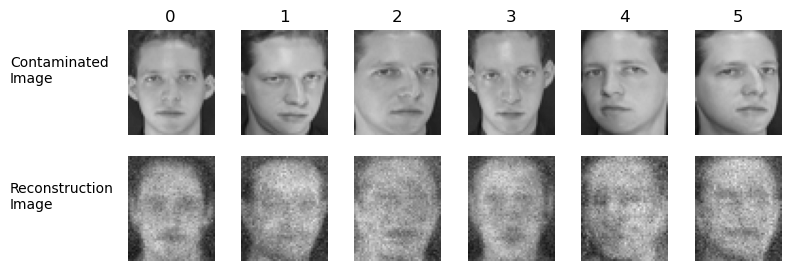

In [17]:
if DEBUG_MODE:
    D, R = cauchy_nmf(X_hat_contaminated, Y_hat)
    X_pred = D @ R
    RMSE = construct_RMSE(X_hat, X_pred)
    print('RMSE(original)=%f' % (RMSE))
    RMSE = construct_RMSE(X_hat_contaminated, X_pred)
    print('RMSE(contaminated)=%f' % (RMSE))
    show_original_and_processed_iamge(
        X_hat, X_pred, image_height, image_width, ["Contaminated\nImage", "Reconstruction\nImage"])

### 5.3 Function for Huber-NMF

- Objective function

$$
    \min_{D, R} \sum_{i=1}^{N} \sum_{j=1}^{M} \ell_{\text {Huber}}\left(X_{i j}-\sum_{k=1}^{K} D_{i k} R_{j k}\right)
$$

$$
    \ell_{\text {huber}}(e)=\left\{\begin{array}{ll}
    e^{2} & \text { if }|e| \leq c \\
    2 c|e|-c^{2} & \text { if }|e| \geq c
    \end{array},\right.
$$

- MUR

$$
    E_{i j}=X_{i j}-\sum_{k=1}^{K} D_{i k} R_{j k}\\
$$
$$
    c=\operatorname{median}(\left|E_{i j}\right|)\\
$$
$$
    W_{i j}=\left\{\begin{array}{cc}1 & \text { if }\left|E_{i j}\right| \leq c \\ \frac{c}{\left|E_{i j}\right|} & \text { otherwise }\end{array}\right.\\
$$
$$
    D_{i k}=D_{i k} \frac{(W \circ X R)_{i k}}{\left(W \circ \left(D R^{T}\right) R\right)_{i k}}\\
$$
$$
    R_{j k}=R_{j k} \frac{\left((W \circ X)^{T} D\right)_{j k}}{\left(\left(W \circ \left(D R^{T}\right)\right)^{T} D\right)_{j k}}
$$

In [20]:
def huber_nmf(X, Y, max_steps=5000, tolerance=0.0005):
    """
    Implements Huber-NMF for data matrix X.
    
    Parameters:
    - X (np.array): Data matrix with shape (m, n) where m is the number of features and n is the number of samples.
    - Y (np.array): Label array for the data matrix X.
    - max_steps (int, optional): Maximum number of iterations for the NMF algorithm. Defaults to 5000.
    - tolerance (float, optional): Convergence tolerance for the update steps. Defaults to 0.0005.
    
    Returns:
    - tuple: A tuple (D_updated, R_updated.T) representing the factorized matrices.
    """

    m = X.shape[0]
    n = X.shape[1]
    if (GPU_MODE == True):
        k = np.unique(Y).size
    else:
        k = len(set(Y))

    # Initialize matrices D and R with random values
    D = np.random.rand(m, k)
    R = np.random.rand(k, n)
    R = R.T
    D_updated = None
    R_updated = None

    for step in range(0, max_steps):

        # Calculate the error matrix
        E = X - (D @ R.T)
        E[E == 0] = np.finfo(np.float32).eps

        # Define the threshold c based on the median absolute deviation of E
        c = np.median(np.abs(E))
        if (c == 0):
            c = np.finfo(np.float32).eps

        # Construct a weight matrix W based on Huber criterion
        condition = np.abs(E) <= c
        W = E.copy()
        W[W == 0] = np.finfo(np.float32).eps
        W[condition] = 1
        W[~condition] = c / np.abs(E[~condition])

        # Update rules for D and R matrices using the Huber-NMF approach
        D_denominator = (W * (D @ R.T)) @ R
        D_denominator[D_denominator == 0] = np.finfo(np.float32).eps
        D_updated = D * ((W * X @ R) / D_denominator)

        R_denominator = (W * (D_updated @ R.T)).T @ D_updated
        R_denominator[R_denominator == 0] = np.finfo(np.float32).eps
        R_updated = R * (((W * X).T @ D_updated) / R_denominator)

        # Calculate errors to check convergence
        D_error = np.sqrt(np.sum((D_updated - D) ** 2) / D.size)
        R_error = np.sqrt(np.sum((R_updated - R) ** 2) / R.size)

        # Check if errors are below the tolerance level
        if D_error < tolerance and R_error < tolerance:
            print("Converged at step:", step)
            break

        # Update matrices D and R
        D = D_updated
        R = R_updated

    print("Stop at step:", step)
    return D_updated, R_updated.T

Converged at step: 443
Stop at step: 443
RMSE(original)=0.075984
RMSE(contaminated)=0.176953


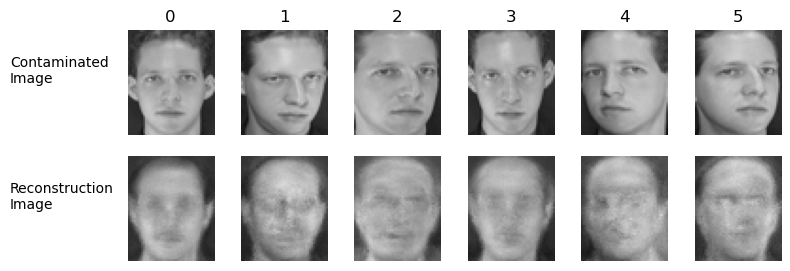

In [22]:
if DEBUG_MODE:
    D, R = huber_nmf(X_hat_contaminated, Y_hat)
    X_pred = D @ R
    RMSE = construct_RMSE(X_hat, X_pred)
    print('RMSE(original)=%f' % (RMSE))
    RMSE = construct_RMSE(X_hat_contaminated, X_pred)
    print('RMSE(contaminated)=%f' % (RMSE))
    show_original_and_processed_iamge(
        X_hat, X_pred, image_height, image_width, ["Contaminated\nImage", "Reconstruction\nImage"])

## 6. Experiments

- Experiment procedure

![experiment_scheme.svg](experiment_scheme/experiment_scheme.svg)


- Sub-experiments

![sub_experiments.svg](experiment_scheme/sub_experiments.svg)



### 6.1 Function for Running Experiments

In [23]:
def run_experiments(dataset, reduce, cfg):
    """
    Run a series of experiments on different datasets with different noise types and different NMF algorithms.
    
    Parameters:
    - dataset (str): Path to the dataset.
    - reduce (int): Dimensionality reduction target.
    - cfg (dict): Configuration dictionary for experiments.
    
    Returns:
    - tuple: A tuple containing the results and the directory where experiment data is stored.
    """
    
    ret = []

    # Create a directory to store experiment data
    experiments_data_dir = "experiment_data_" + \
        datetime.datetime.now().strftime('_%Y_%m_%d__%H_%M_%S__%f__')[:-4]
    os.mkdir(experiments_data_dir)

    cfg["dataset"] = dataset
    cfg["reduce"] = reduce
    with open(experiments_data_dir + "/experiments_config.json", 'w') as file:
        file.write(repr(cfg))

    print("Load Data and Preprocessing...")
    X_hat, Y_hat, image_width, image_height = load_data(
        root=dataset, reduce=reduce)
    print("Load Data and Preprocessing. [OK]")

    print("Randomly sampling subset...")
    if (GPU_MODE == True):
        X_hat = np.asnumpy(X_hat)
        Y_hat = np.asnumpy(Y_hat)

    # Create a series of data subsets for experiments
    subsets = []
    for subset_id in range(0, cfg["sub_experiment_num"]):
        np.random.seed(subset_id)
        X_subset_train, X_subset_test, Y_subset_train, Y_subset_test = train_test_split(
            X_hat.T, Y_hat, train_size=cfg["subset_size"], stratify=Y_hat)

        if (GPU_MODE == True):
            X_subset_train = np.asarray(X_subset_train)
            X_subset_test = np.asarray(X_subset_test)
            Y_subset_train = np.asarray(Y_subset_train)
            Y_subset_test = np.asarray(Y_subset_test)

        subsets.append({"X_train": X_subset_train.T, "X_test": X_subset_test.T,
                       "Y_train": Y_subset_train, "Y_test": Y_subset_test,
                        "X_train_npy": "subset_%d_X_train.npy" % (subset_id + 1),
                        "X_test_npy": "subset_%d_X_test.npy" % (subset_id + 1),
                        "Y_train_npy": "subset_%d_Y_train.npy" % (subset_id + 1),
                        "Y_test_npy": "subset_%d_Y_test.npy" % (subset_id + 1)})
        np.save(experiments_data_dir + "/" +
                subsets[subset_id]["X_train_npy"], subsets[subset_id]["X_train"])
        np.save(experiments_data_dir + "/" +
                subsets[subset_id]["X_test_npy"], subsets[subset_id]["X_test"])
        np.save(experiments_data_dir + "/" +
                subsets[subset_id]["Y_train_npy"], subsets[subset_id]["Y_train"])
        np.save(experiments_data_dir + "/" +
                subsets[subset_id]["Y_test_npy"], subsets[subset_id]["Y_test"])

    if (GPU_MODE == True):
        X_hat = np.asarray(X_hat)
        Y_hat = np.asarray(Y_hat)

    print("Randomly sampling subset. [OK]")

    for subset_id, subset in enumerate(subsets):

        # Start a new sub-experiment
        log = "Run sub_experiment(%d/%d)" % (subset_id + 1, len(subsets))
        print(log + "...")

        # Iterate over each noise function specified in the configuration
        for noise_func in cfg["noise_list"]:

            # Contaminate the dataset using the specified noise function
            print(log + "contaminate(%s)..." % (noise_func.__name__))
            subset["X_train_" + noise_func.__name__] = contaminate_dataset(
                subset["X_train"], image_height, image_width, noise_func)

            # Save the contaminated dataset
            subset["X_train_" + noise_func.__name__ +
                   "_npy"] = "subset_%d_X_train_%s.npy" % (subset_id + 1, noise_func.__name__)
            np.save(experiments_data_dir + "/" +
                    subset["X_train_" + noise_func.__name__ + "_npy"], subset["X_train_" + noise_func.__name__])
            print(log + "contaminate(%s). [OK]" % (noise_func.__name__))

            # Iterate over each NMF function specified in the configuration
            for nmf_func in cfg["nmf_list"]:

                print(log + "%s(%s)" %
                      (noise_func.__name__, nmf_func.__name__))
                T0 = time.time()

                # Apply the NMF function on the contaminated dataset
                D, R = nmf_func(subset["X_train_" + noise_func.__name__],
                                subset["Y_train"], tolerance=cfg["tolerance"], max_steps=cfg["max_steps"])
                X_subset_pred = D @ R

                # Calculate RMSE, accuracy, and NMI metrics
                rmse = construct_RMSE(subset["X_train"], X_subset_pred)
                Y_subset_pred = assign_cluster_label(R.T, subset["Y_train"])
                acc = calculate_accuracy(subset["Y_train"], Y_subset_pred)
                nmi = calculate_NMI(subset["Y_train"], Y_subset_pred)

                T1 = time.time()
                time_cost = T1 - T0
                print(log + "%s(%s) [OK][rmse:%.6f, acc:%.6f, nmi:%.6f][%.2f seconds]" %
                      (noise_func.__name__, nmf_func.__name__, rmse, acc, nmi, time_cost))

                # Append results to the results list
                ret.append({
                    "subset_id": subset_id + 1,
                    "noise": noise_func.__name__,
                    "algorithm": nmf_func.__name__,
                    "RMSE": rmse,
                    "Acc": acc,
                    "NMI": nmi,
                    "time_cost": time_cost,
                    "image_width": image_width,
                    "image_height": image_height,
                    "D_pny": "subset_%d_X_train_%s_%s_D.npy" % (subset_id + 1, noise_func.__name__, nmf_func.__name__),
                    "R_pny": "subset_%d_X_train_%s_%s_R.npy" % (subset_id + 1, noise_func.__name__, nmf_func.__name__),
                    "DR_pny": "subset_%d_X_train_%s_%s_X_pred_RMSE(%.6f)_Acc(%.6f)_NMI(%.6f)_timecost(%.2f).npy" % (subset_id + 1, noise_func.__name__, nmf_func.__name__, rmse, acc, nmi, time_cost)
                })

                if (GPU_MODE == True):
                    D = np.asnumpy(D)
                    R = np.asnumpy(R)
                    X_subset_pred = np.asnumpy(X_subset_pred)

                np.save(experiments_data_dir + "/" + ret[-1]["D_pny"], D)
                np.save(experiments_data_dir + "/" + ret[-1]["R_pny"], R)
                np.save(experiments_data_dir + "/" +
                        ret[-1]["DR_pny"], X_subset_pred)

        # End of the sub-experiment
        log = "Run sub_experiment(%d/%d)" % (subset_id + 1, len(subsets))
        print(log + ". [OK]")

    # Save the final experiment results to a JSON file
    with open(experiments_data_dir + "/experiments_result.json", 'w') as file:
        file.write(json.dumps(ret, indent=4))

    # Return the results and the directory where they are stored
    return ret, experiments_data_dir

### 6.2 Experiments on ORL Dataset

In [24]:
experiments_config = {
    "nmf_list": [l2_nmf, cauchy_nmf, huber_nmf],
    "noise_list": [gauss_noise, salt_and_pepper_noise, block_occlusion_noise],
    "sub_experiment_num": 5,
    "subset_size": 0.9,
    "tolerance": 0.0005,
    "max_steps": 5000
}

orl_experiments_result, orl_experiments_data_dir = run_experiments(
    dataset='../data/ORL' if not USE_COLABS else 'data/ORL', reduce=2, cfg=experiments_config)

Load Data and Preprocessing...
Load Data and Preprocessing. [OK]
Randomly sampling subset...
Randomly sampling subset. [OK]
Run sub_experiment(1/5)...
Run sub_experiment(1/5)contaminate(block_occlusion_noise)...
Run sub_experiment(1/5)contaminate(block_occlusion_noise). [OK]
Run sub_experiment(1/5)block_occlusion_noise(l2_nmf)
Converged at step: 450
Stop at step: 450
Run sub_experiment(1/5)block_occlusion_noise(l2_nmf) [rmse:0.218075, acc:0.238889, nmi:0.424404][8.72 seconds][OK]
Run sub_experiment(1/5)block_occlusion_noise(cauchy_nmf)
Converged at step: 412
Stop at step: 412
Run sub_experiment(1/5)block_occlusion_noise(cauchy_nmf) [rmse:0.217089, acc:0.230556, nmi:0.418562][6.00 seconds][OK]
Run sub_experiment(1/5)block_occlusion_noise(huber_nmf)
Converged at step: 463
Stop at step: 463
Run sub_experiment(1/5)block_occlusion_noise(huber_nmf) [rmse:0.216605, acc:0.216667, nmi:0.409928][15.52 seconds][OK]
Run sub_experiment(1/5)contaminate(salt_and_pepper_noise)...
Run sub_experiment(1/

### 6.3 Experiments on CroppedYaleB Dataset

In [25]:
experiments_config = {
    "nmf_list": [l2_nmf, cauchy_nmf, huber_nmf],
    "noise_list": [gauss_noise, salt_and_pepper_noise, block_occlusion_noise],
    "sub_experiment_num": 5,
    "subset_size": 0.9,
    "tolerance": 0.0005,
    "max_steps": 5000
}

yaleb_experiments_result, yaleb_experiments_data_dir = run_experiments(
    dataset='../data/CroppedYaleB' if not USE_COLABS else 'data/CroppedYaleB', reduce=4, cfg=experiments_config)

Load Data and Preprocessing...
Load Data and Preprocessing. [OK]
Randomly sampling subset...
Randomly sampling subset. [OK]
Run sub_experiment(1/5)...
Run sub_experiment(1/5)contaminate(block_occlusion_noise)...
Run sub_experiment(1/5)contaminate(block_occlusion_noise). [OK]
Run sub_experiment(1/5)block_occlusion_noise(l2_nmf)
Converged at step: 691
Stop at step: 691
Run sub_experiment(1/5)block_occlusion_noise(l2_nmf) [rmse:0.305233, acc:0.083333, nmi:0.076272][7.75 seconds][OK]
Run sub_experiment(1/5)block_occlusion_noise(cauchy_nmf)
Converged at step: 542
Stop at step: 542
Run sub_experiment(1/5)block_occlusion_noise(cauchy_nmf) [rmse:0.304117, acc:0.082413, nmi:0.076902][95.70 seconds][OK]
Run sub_experiment(1/5)block_occlusion_noise(huber_nmf)
Converged at step: 1001
Stop at step: 1001
Run sub_experiment(1/5)block_occlusion_noise(huber_nmf) [rmse:0.299674, acc:0.087937, nmi:0.093527][28.30 seconds][OK]
Run sub_experiment(1/5)contaminate(salt_and_pepper_noise)...
Run sub_experiment

### 6.4 Function for Analyzing Experiments Results

- Analyze

![Analyze.svg](experiment_scheme/Analyze.svg)

*If you have previously run the experiments, you can use the code below to load the existing experiment results directory into the current environment for further analysis*

In [73]:
# orl_experiments_result = None
# orl_experiments_data_dir = "experiment_data__2023_10_06__11_42_10__6178_final_orl"
# with open(orl_experiments_data_dir + "/experiments_result.json", 'r') as file:
#     orl_experiments_result = json.loads(file.read())

# yaleb_experiments_result = None
# yaleb_experiments_data_dir = "experiment_data__2023_10_06__12_15_56__0343_final_yaleb"
# with open(yaleb_experiments_data_dir + "/experiments_result.json", 'r') as file:
#     yaleb_experiments_result = json.loads(file.read())

In [74]:
def analyze_experiments_result(experiments_result):
    """
    Analyze and aggregate the results of experiments based on noise type and NMF algorithm.
    
    Parameters:
    - experiments_result (list of dict): A list of experiment results. 
    
    Returns:
    - list of dict: An aggregated list of experiment results.
    """

    np = numpy # use CPU
    ret = []

    # Extract unique noise types and algorithms used in the experiments
    noise_list = list(set([experiment["noise"]
                      for experiment in experiments_result]))[::-1]
    algorithm_list = list(set([experiment["algorithm"]
                          for experiment in experiments_result]))

    # Iterate over each noise type
    for noise in noise_list:

        # Initialize the result structure for each noise type
        noise_experiments_result = {"noise": noise,
                                    "RMSE": {"mean": [], "std": []},
                                    "Acc": {"mean": [], "std": []},
                                    "NMI": {"mean": [], "std": []},
                                    "algorithms": algorithm_list}

        # Read the results from each algorithm
        for algorithm in algorithm_list:
            if algorithm not in noise_experiments_result.keys():
                noise_experiments_result[algorithm] = {
                    "RMSE": [], "Acc": [], "NMI": []}
            for experiemnt in experiments_result:
                if (noise != experiemnt["noise"]):
                    continue
                if algorithm == experiemnt["algorithm"]:
                    noise_experiments_result[algorithm]["RMSE"].append(
                        experiemnt["RMSE"])
                    noise_experiments_result[algorithm]["Acc"].append(
                        experiemnt["Acc"])
                    noise_experiments_result[algorithm]["NMI"].append(
                        experiemnt["NMI"])

        # Calculate mean and standard deviation for each algorithm and metric
        for algorithm in algorithm_list:
            noise_experiments_result["RMSE"]["mean"].append(
                np.mean(noise_experiments_result[algorithm]["RMSE"]))
            noise_experiments_result["Acc"]["mean"].append(
                np.mean(noise_experiments_result[algorithm]["Acc"]))
            noise_experiments_result["NMI"]["mean"].append(
                np.mean(noise_experiments_result[algorithm]["NMI"]))
            noise_experiments_result["RMSE"]["std"].append(
                np.std(noise_experiments_result[algorithm]["RMSE"]))
            noise_experiments_result["Acc"]["std"].append(
                np.std(noise_experiments_result[algorithm]["Acc"]))
            noise_experiments_result["NMI"]["std"].append(
                np.std(noise_experiments_result[algorithm]["NMI"]))

        ret.append(noise_experiments_result)

    if GPU_MODE:
        np = cupy

    return ret

## 7. Generate Charts for the Experiments Results

In [75]:
orl_experiments_results_analyzed = analyze_experiments_result(orl_experiments_result)
yaleb_experiments_results_analyzed = analyze_experiments_result(yaleb_experiments_result)
# print(json.dumps(orl_experiments_results_analyzed, indent=4))
# print(json.dumps(yaleb_experiments_results_analyzed, indent=4))

### 7.2 Function for Generate Charts

In [76]:
LATEX_STR = {
    "huber_nmf": "Huber-NMF",
    "cim_nmf": "CIM-NMF",
    "l1_nmf": "$L_1$-NMF",
    "l2_nmf": "$L_2$-NMF",
    "l21_nmf": "$L_{2,1}$-NMF",
    "cauchy_nmf": "Cauchy-NMF",
    "salt_and_pepper_noise": "salt and pepper noise",
    "gauss_noise": "gaussian noise",
    "block_occlusion_noise": "block occlusion noise"
}

In [77]:
def generate_experiments_result_chart(experiments_result_analyzed):
    """
    Generate a set of plots showing the performance of various NMF algorithms 
    on datasets contaminated with different noise types.

    Parameters:
    - experiments_result_analyzed (list): A list of aggregated experiment results.
    """

    noise_experiments = []
    for noise in ["gauss_noise", "salt_and_pepper_noise", "block_occlusion_noise"]:
        for result in experiments_result_analyzed:
            if result["noise"] == noise:
                noise_experiments.append(result)

    # Initialize a figure
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14, 10))
    linestyles = ['-', '--', '-.', ':']
    markstyles = ['o', 'v', 's', '*', 'X', 'p']

    # Iterate through each noise type and plot the performance metrics
    for row in range(0, 3):
        for i, alg in enumerate(noise_experiments[row]["algorithms"]):
            # Plot RMSE
            ax[row, 1].plot(range(len(noise_experiments[row][alg]["RMSE"])), noise_experiments[row][alg]
                            ["RMSE"], linestyle=linestyles[i % len(linestyles)], marker=markstyles[i % len(markstyles)], label=LATEX_STR[alg])

            # Plot Accuracy
            ax[row, 2].plot(range(len(noise_experiments[row][alg]["Acc"])), noise_experiments[row][alg]
                            ["Acc"], linestyle=linestyles[i % len(linestyles)], marker=markstyles[i % len(markstyles)], label=LATEX_STR[alg])

            # Plot NMI
            ax[row, 3].plot(range(len(noise_experiments[row][alg]["NMI"])), noise_experiments[row][alg]
                            ["NMI"], linestyle=linestyles[i % len(linestyles)], marker=markstyles[i % len(markstyles)], label=LATEX_STR[alg])

        # Set labels
        ax[row, 1].set_xlabel("sub-experiments")
        ax[row, 2].set_xlabel("sub-experiments")
        ax[row, 3].set_xlabel("sub-experiments")
        ax[row, 1].set_ylabel("RMSE")
        ax[row, 2].set_ylabel("Acc")
        ax[row, 3].set_ylabel("NMI")

    # Adding text to indicate the noise type in the first column
    noise_list = [i["noise"] for i in noise_experiments]
    for row, noise in enumerate(noise_list):
        ax[row, 0].text(0.5, 0.5, horizontalalignment='center',
                        verticalalignment='center', s=LATEX_STR[noise], size=12)
        ax[row, 0].axis("off")

    # Adding a legend to the plot
    ax[2, 1].legend(loc='upper left', bbox_to_anchor=(-1.1, 0.3),
                    handlelength=2, borderaxespad=0., labelspacing=1)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

#### 7.2.1 Generate ORL Datset Experiment Charts

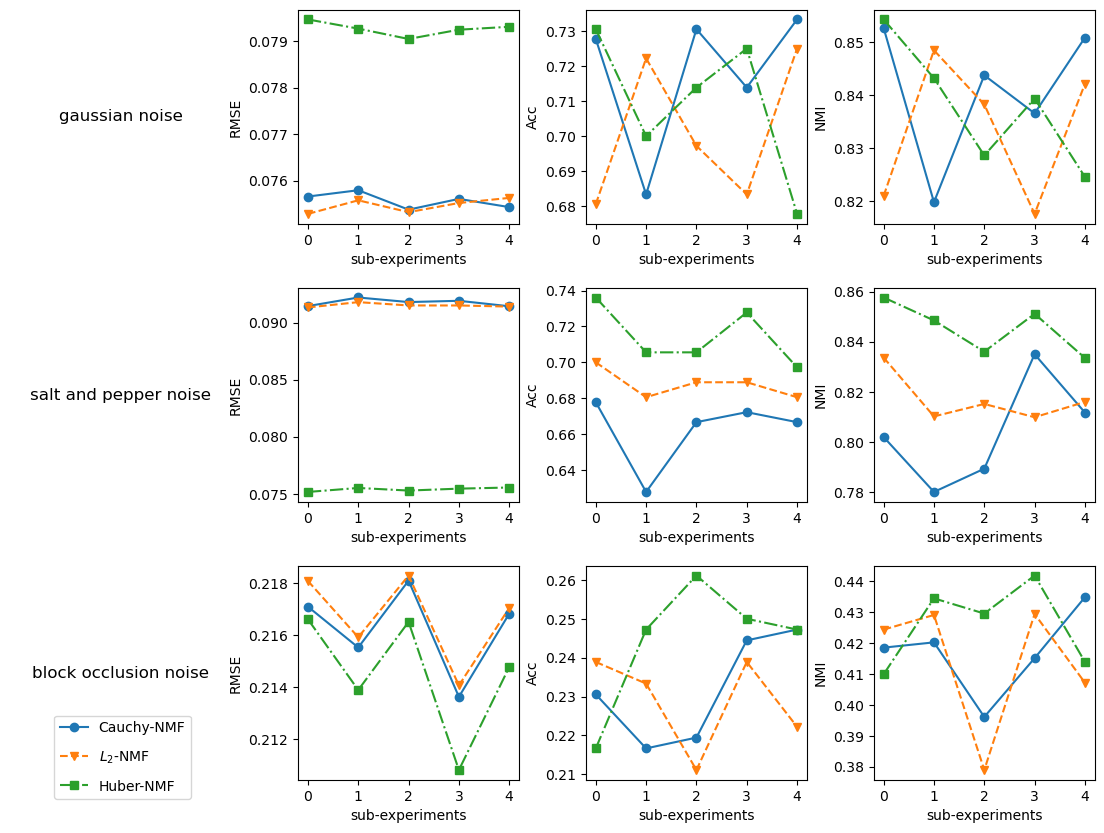

In [78]:
generate_experiments_result_chart(orl_experiments_results_analyzed)

#### 7.2.2 Generate CroppedYaleB Datset Experiment Charts

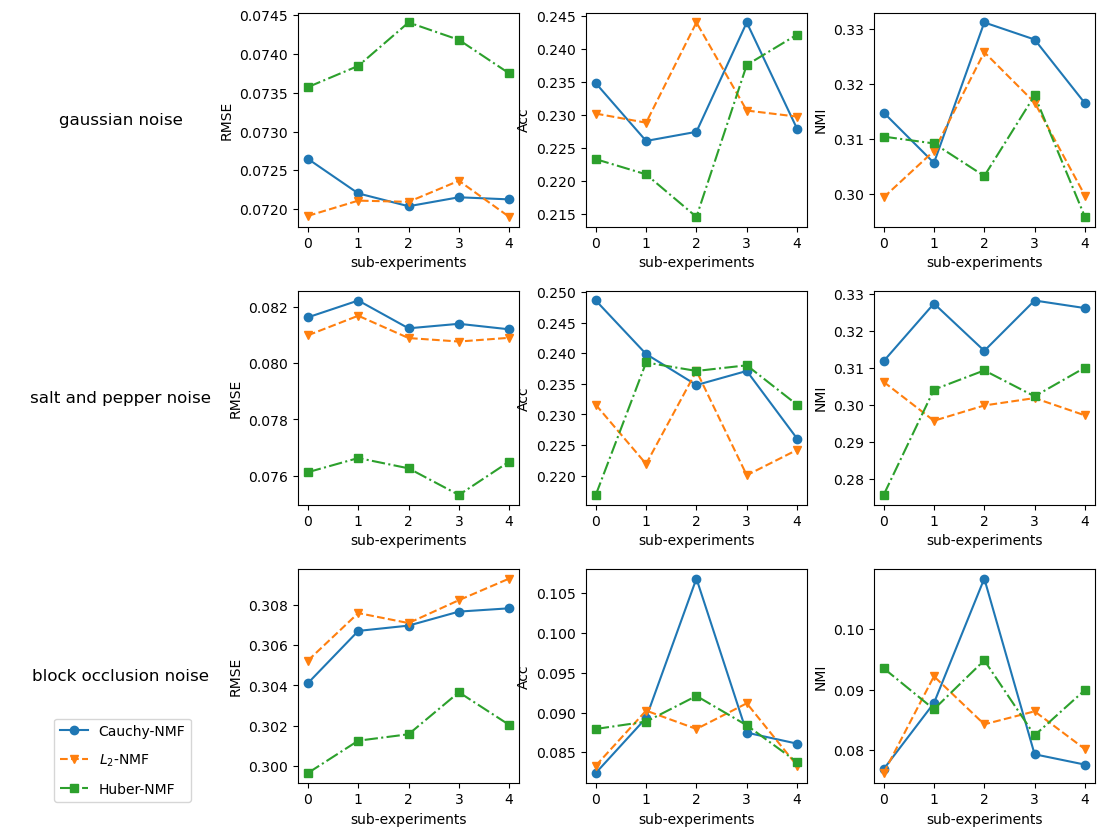

In [79]:
generate_experiments_result_chart(yaleb_experiments_results_analyzed)

### 7.3 Function for Generate Tables

In [80]:
def generate_latex_table(experiments_result_analyzed):
    """
    Generates a LaTeX table representation for given experimental results.

    Args:
    - experiments_result_analyzed (list): A list of dictionaries containing analyzed experimental results.

    Returns:
    - str: A string containing the LaTeX table representation of the results.
    """

    str = ""
    str += "\\begin{table}\r\n"
    str += "    \\centering\r\n"
    str += "    \\caption{XXXXXXXXXXXXXX}\r\n"
    str += "    \\begin{tabular}{cccccc}\r\n"
    str += "    \\toprule\r\n"
    str += "    % \\hline\r\n"
    str += "    % \\multirow{2}{*}{Noise} &  & \\multicolumn{3}{c|}{NMF} \\\\\r\n"
    str += "    % \\cline{3-5}\r\n"
    str += "    \\parbox{2.5cm}{\\centering \\textbf{%s}} & \\multicolumn{2}{c}{\\parbox{2.5cm}{\\centering \\textbf{%s}}} & \\parbox{2.5cm}{\\centering \\textbf{%s}} & \\parbox{2.5cm}{\\centering \\textbf{%s}} & \\parbox{2.5cm}{\\centering \\textbf{%s}} \\\\\r\n" % (
        "Noise",
        "Metrics",
        LATEX_STR[experiments_result_analyzed[0]["algorithms"][0]],
        LATEX_STR[experiments_result_analyzed[0]["algorithms"][1]],
        LATEX_STR[experiments_result_analyzed[0]["algorithms"][2]])
    str += "    \\toprule\r\n"

    for noise in experiments_result_analyzed:
        if noise["noise"] == "original":
            continue
        noise_str = noise["noise"].replace("_", " \\\\ ")
        RMSE_mean_str = " & ".join("%6f" % i if i != min(
            noise["RMSE"]["mean"]) else "\\textcolor{blue}{{\\textbf{%6f}}}" % i for i in noise["RMSE"]["mean"])
        RMSE_std_str = " & ".join("%6f" % i if i != min(
            noise["RMSE"]["std"]) else "\\textcolor{blue}{{\\textbf{%6f}}}" % i for i in noise["RMSE"]["std"])
        Acc_mean_str = " & ".join("%6f" % i if i != max(
            noise["Acc"]["mean"]) else "\\textcolor{blue}{{\\textbf{%6f}}}" % i for i in noise["Acc"]["mean"])
        Acc_std_str = " & ".join("%6f" % i if i != min(
            noise["Acc"]["std"]) else "\\textcolor{blue}{{\\textbf{%6f}}}" % i for i in noise["Acc"]["std"])
        NMI_mean_str = " & ".join("%6f" % i if i != max(
            noise["NMI"]["mean"]) else "\\textcolor{blue}{{\\textbf{%6f}}}" % i for i in noise["NMI"]["mean"])
        NMI_std_str = " & ".join("%6f" % i if i != min(
            noise["NMI"]["std"]) else "\\textcolor{blue}{{\\textbf{%6f}}}" % i for i in noise["NMI"]["std"])
        str += "        \\multirow{6}{*}{\\parbox{2cm}{\\centering %s}} & \\multirow{2}{*}{RMSE} & mean & %s \\\\ \r\n" % (
            noise_str, RMSE_mean_str)
        str += "        & & std  & %s \\\\\r\n" % (RMSE_std_str)
        str += "        \\cline{2-6}\r\n"
        str += "        & \\multirow{2}{*}{Acc}  & mean & %s \\\\ \r\n" % (
            Acc_mean_str)
        str += "        & & std  & %s \\\\\r\n" % (Acc_std_str)
        str += "        \\cline{2-6}\r\n"
        str += "        & \\multirow{2}{*}{NMI}  & mean & %s \\\\ \r\n" % (
            NMI_mean_str)
        str += "        & & std  & %s \\\\\r\n" % (NMI_std_str)
        str += "        \\toprule\r\n"

    str += "    \\end{tabular}\r\n"
    str += "\\end{table}\r\n"

    return str

#### 7.3.1 Generate ORL Datset Experiment Table

In [81]:
latex_table_str = generate_latex_table(orl_experiments_results_analyzed)
print(latex_table_str)

\begin{table}
    \centering
    \caption{XXXXXXXXXXXXXX}
    \begin{tabular}{cccccc}
    \toprule
    % \hline
    % \multirow{2}{*}{Noise} &  & \multicolumn{3}{c|}{NMF} \\
    % \cline{3-5}
    \parbox{2.5cm}{\centering \textbf{Noise}} & \multicolumn{2}{c}{\parbox{2.5cm}{\centering \textbf{Metrics}}} & \parbox{2.5cm}{\centering \textbf{Cauchy-NMF}} & \parbox{2.5cm}{\centering \textbf{$L_2$-NMF}} & \parbox{2.5cm}{\centering \textbf{Huber-NMF}} \\
    \toprule
        \multirow{6}{*}{\parbox{2cm}{\centering salt \\ and \\ pepper \\ noise}} & \multirow{2}{*}{RMSE} & mean & 0.091753 & 0.091500 & \textcolor{blue}{{\textbf{0.075391}}} \\ 
        & & std  & 0.000291 & 0.000158 & \textcolor{blue}{{\textbf{0.000147}}} \\
        \cline{2-6}
        & \multirow{2}{*}{Acc}  & mean & 0.662222 & 0.687778 & \textcolor{blue}{{\textbf{0.714444}}} \\ 
        & & std  & 0.017708 & \textcolor{blue}{{\textbf{0.007158}}} & 0.014845 \\
        \cline{2-6}
        & \multirow{2}{*}{NMI}  & mean & 0.80358

#### 7.3.2 Generate CroppedYaleB Datset Experiment Table

In [82]:
latex_table_str = generate_latex_table(yaleb_experiments_results_analyzed)
print(latex_table_str)

\begin{table}
    \centering
    \caption{XXXXXXXXXXXXXX}
    \begin{tabular}{cccccc}
    \toprule
    % \hline
    % \multirow{2}{*}{Noise} &  & \multicolumn{3}{c|}{NMF} \\
    % \cline{3-5}
    \parbox{2.5cm}{\centering \textbf{Noise}} & \multicolumn{2}{c}{\parbox{2.5cm}{\centering \textbf{Metrics}}} & \parbox{2.5cm}{\centering \textbf{Cauchy-NMF}} & \parbox{2.5cm}{\centering \textbf{$L_2$-NMF}} & \parbox{2.5cm}{\centering \textbf{Huber-NMF}} \\
    \toprule
        \multirow{6}{*}{\parbox{2cm}{\centering salt \\ and \\ pepper \\ noise}} & \multirow{2}{*}{RMSE} & mean & 0.081544 & 0.081052 & \textcolor{blue}{{\textbf{0.076166}}} \\ 
        & & std  & 0.000376 & \textcolor{blue}{{\textbf{0.000327}}} & 0.000461 \\
        \cline{2-6}
        & \multirow{2}{*}{Acc}  & mean & \textcolor{blue}{{\textbf{0.237293}}} & 0.226980 & 0.232413 \\ 
        & & std  & 0.007312 & \textcolor{blue}{{\textbf{0.006399}}} & 0.008166 \\
        \cline{2-6}
        & \multirow{2}{*}{NMI}  & mean & \textco

### 7.4 Function for Display Algorithm Reconstruction Images

In [117]:
def display_algorithm_reconstruction_examples(experiments_data_dir, image_id=None):
    """
    Displays reconstruction examples for various algorithms and noise types.

    Args:
    - experiments_data_dir (str): Directory path containing experiment data (json results, npy files).
    - image_id (int, optional): The ID of the image to display. If not provided, a random image ID is chosen.
    """

    np = numpy

    # Load experiment results from JSON file.
    experiments_result = None
    with open(experiments_data_dir + "/experiments_result.json", 'r') as file:
        experiments_result = json.loads(file.read())
    if experiments_result == None:
        print("error")
        return

    # If image_id is not provided, randomly select one.
    if (image_id == None):
        image_id = int(np.random.rand() * 100)
        print("random image_id:", image_id)

    image_height = experiments_result[0]["image_height"]
    image_width = experiments_result[0]["image_width"]

    # Load original and noisy data.
    noise_list = []
    X_hat_file = []
    Y_hat_file = []
    for result in experiments_result:
        if result["subset_id"] != 1:
            continue
        if result["noise"] in noise_list:
            continue
        X_hat_file.append(np.load(experiments_data_dir +
                                  '/subset_1_X_train_%s.npy' % (result["noise"])))
        Y_hat_file.append(np.load(experiments_data_dir +
                                  '/subset_1_Y_train.npy'))
        noise_list.append(result["noise"])

    noise_list = noise_list[::-1]
    X_hat_file = X_hat_file[::-1]

    # Extract unique algorithms from results.
    nmf_list = list(set(entry['algorithm'] for entry in experiments_result))
    X_hat_file_pred = []

    # Load reconstructions for each algorithm and noise.
    for nmf in nmf_list:
        col = []
        for noise in noise_list:
            entry = next(
                (item for item in experiments_result if item['noise'] == noise and item['algorithm'] == nmf), None)
            if entry:
                col.append(np.load(experiments_data_dir + "/" +
                                   entry["DR_pny"]))
            else:
                col.append(None)
        X_hat_file_pred.append(col)

    # Initialize plot with rows for each noise type and columns for each algorithm.
    fig, axs = plt.subplots(nrows=len(noise_list),
                            ncols=len(nmf_list)+2, figsize=(10, 5))

    for col in range(0, len(nmf_list)+2):
        for row in range(0, len(noise_list)):
            axs[row, col].axis('off')

    # Display images in the matrix format.
    img = np.load(experiments_data_dir + '/subset_1_X_train.npy')[
        :, image_id].reshape(image_height, image_width)
    axs[1, 0].imshow(img,
                     cmap=plt.cm.gray, vmax=1, vmin=0)
    for noise_id, noise in enumerate(noise_list):
        img = X_hat_file[noise_id][:, image_id].reshape(
            image_height, image_width)
        axs[noise_id - 1, 1].imshow(img, cmap=plt.cm.gray, vmax=1, vmin=0)

    for col_id, col in enumerate(X_hat_file_pred):
        for row_id, row in enumerate(col):
            if row_id == 0:
                axs[0, col_id +
                    2].set_title(LATEX_STR[nmf_list[col_id]]+"\nreconstructions")
            img = row[:, image_id].reshape(image_height, image_width)
            axs[row_id - 1, col_id +
                2].imshow(img, cmap=plt.cm.gray, vmax=1, vmin=0)

    axs[0, 0].set_title("Original")
    axs[0, 1].set_title("Contaminated\nby\ndifferent noise")

    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

    if GPU_MODE:
        np = cupy

#### 7.4.1 Displaying ORL Dataset Reconstructions

random image_id: 48


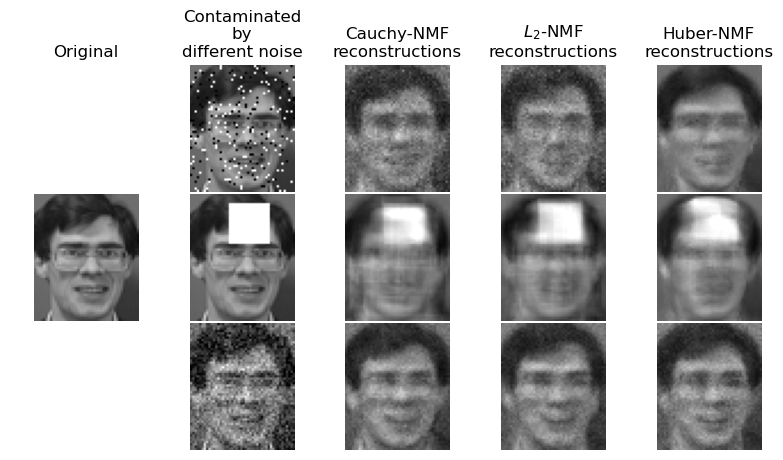

In [116]:
display_algorithm_reconstruction_examples(orl_experiments_data_dir)

#### 7.4.2 Displaying CroppedYaleB Dataset Reconstructions

random image_id: 47


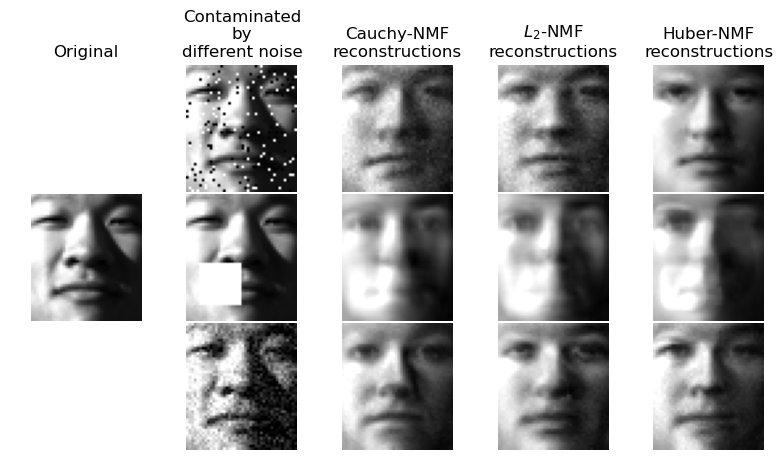

In [133]:
display_algorithm_reconstruction_examples(yaleb_experiments_data_dir)

### 7.5 Function for Display noise examples

In [145]:
def display_noise_example(experiments_data_dir):
    np = numpy

    experiments_result = None
    with open(experiments_data_dir + "/experiments_result.json", 'r') as file:
        experiments_result = json.loads(file.read())
    if experiments_data_dir == None:
        print("error")
        return

    image_height = experiments_result[0]["image_height"]
    image_width = experiments_result[0]["image_width"]

    # load npy
    noise_list = []
    X_hat_file = []
    Y_hat_file = []
    for result in experiments_result:
        if result["subset_id"] != 1:
            continue
        if result["noise"] == "original":
            continue
        if result["noise"] in noise_list:
            continue
        X_hat_file.append(np.load(experiments_data_dir +
                                  '/subset_1_X_train_%s.npy' % (result["noise"])))
        Y_hat_file.append(np.load(experiments_data_dir +
                                  '/subset_1_Y_train.npy'))
        noise_list.append(result["noise"])

    image_number = 12
    image_ids = np.random.choice(
        np.array(list(set(Y_hat_file[0]))), image_number, replace=False)
    print("random image list: ", image_ids)
    fig, axs = plt.subplots(nrows=len(noise_list) + 1,
                            ncols=image_number, figsize=(10, 4.05))
    for col in range(0, image_number):

        img = np.load(experiments_data_dir +
                      '/subset_1_X_train.npy')[:, image_ids[col]].reshape(image_height, image_width)
        axs[0, col].imshow(img, cmap=plt.cm.gray, vmax=1, vmin=0)
        axs[0, col].axis('off')

        for i in range(0, len(noise_list)):
            img = X_hat_file[i][:, image_ids[col]].reshape(
                image_height, image_width)
            axs[i+1, col].imshow(img, cmap=plt.cm.gray, vmax=1, vmin=0)
            axs[i+1, col].axis('off')
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()

    if GPU_MODE:
        np = cupy


#### 7.5.1 Displaying ORL Dataset noise examples

random image list:  [ 2 13  7 20 32 16 12 34 27 28  5 36]


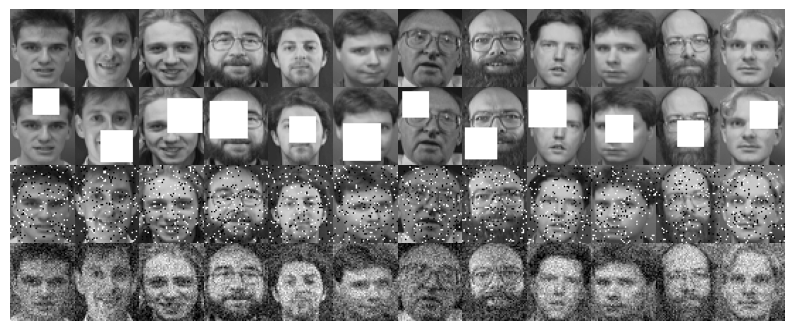

In [146]:
display_noise_example(orl_experiments_data_dir)

#### 7.5.2 Displaying CroppedYaleB Dataset noise examples

random image list:  [29 28 10 32 26  1 34 22 31 16 17  3]


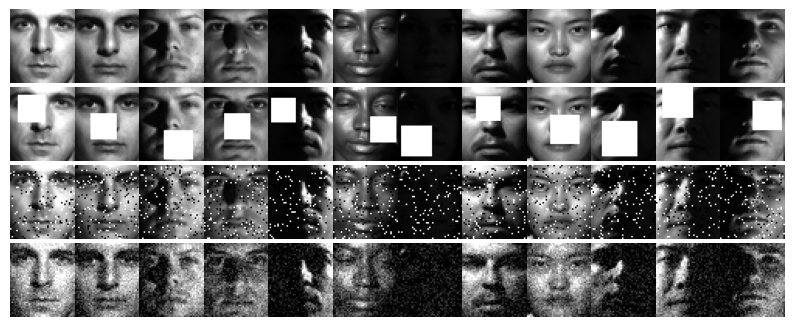

In [144]:
display_noise_example(yaleb_experiments_data_dir)